

## Importing Libraries



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import glob
import shutil
import random
import cv2
from tqdm import tqdm
from PIL import Image
from IPython.display import clear_output
%matplotlib inline

## Downloading Dataset

In [ ]:
!pip install fastai==2.4
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
path = coco_path
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths = np.random.choice(paths, 10000, replace=False) # choosing 1000 images randomly


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Function for resizing image

In [ ]:
def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

In [ ]:
resizedvar = False
train_imgs =[]
test_imgs =[]


if not resizedvar:
    resized_imgs = []
    for i in tqdm(paths):
        im = Image.open(i)
        im = np.array(im)
        resized = resize_img(im)
        resized_imgs.append(resized)
        
    resizedvar = True
    
#allocating the training images and testing images with random indices    
randidxdata = np.random.permutation(10000)
trainingidx = randidxdata[:7000]
testidx = randidxdata[7000:]

#for loops to assign the images
for i in tqdm(trainingidx):
    train_imgs.append(resized_imgs[i])
    
for i in tqdm(testidx):
    test_imgs.append(resized_imgs[i])

100%|██████████| 3000/3000 [00:00<00:00, 925894.92it/s]


## DataLoader

In [ ]:
class ColorData(Dataset):
    def __init__(self, train = 1):
        #data = resized_imgs
        if train == 1:
            self.images = train_imgs
            self.transforms = transforms.Compose([
                transforms.RandomHorizontalFlip(),
            ])
        elif train == 0:
            self.images = test_imgs
        
        self.train = train
        self.images = self.images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx]).convert('RGB')
        lab_imgs = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        lab_imgs = transforms.ToTensor()(lab_imgs)
        L = lab_imgs[[0], ...] / 50. - 1. # Between -1 and 1
        ab = lab_imgs[[1, 2], ...] / 110. # Between -1 and 1
        
        return L, ab

In [ ]:
traindataset = ColorData(train = 1)
trainloader = DataLoader(traindataset, batch_size=10, shuffle=True, num_workers=0)

testdataset = ColorData(train = 0)
testloader = DataLoader(testdataset, batch_size=10, num_workers=0)

data = next(iter(trainloader))
Ls, ab = data
print(Ls.shape, ab.shape)
print(len(trainloader), len(testloader))

torch.Size([10, 1, 256, 256]) torch.Size([10, 2, 256, 256])
700 300


# Generator Network

## Singular Unet Block

In [ ]:
class UnetBlk(nn.Module):
    def __init__(self, filnum, co, submodule=None, in_channel=None, bottleneck=False, outermost=False):
        super().__init__()
        #variable to check if current layer is the outermost layer
        self.outermost = outermost
        
        #if not specified, input channel = ci
        if in_channel is None: 
            in_channel = filnum
            
        #initializing the layers
        downconv = nn.Conv2d(in_channel, co, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(co)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(filnum)
        
        if outermost:
            upconv = nn.ConvTranspose2d(co * 2, filnum, kernel_size=4,stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        
        elif bottleneck:
            upconv = nn.ConvTranspose2d(co, filnum, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        
        else:
            upconv = nn.ConvTranspose2d(co * 2, filnum, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            model = down + [submodule] + up
        
        #creating the model from the list
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

## Unet Network

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channel=1, out_channel=2, layers=8, filnum=64):
        super().__init__()
        
        #bottleneck layer
        unetblock = UnetBlk(filnum * 8, filnum * 8, bottleneck=True)
        
        #next 3 layers
        for i in range(layers - 5):
            unetblock = UnetBlk(filnum * 8, filnum * 8, submodule=unetblock)
        
        filout = filnum * 8
        
        #next 3 layers
        for i in range(3):
            unetblock = UnetBlk(filout // 2, filout, submodule=unetblock)
            filout //= 2
        
        #final layer
        self.model = UnetBlk(out_channel, filout, in_channel=in_channel, submodule=unetblock, outermost=True)
    
    def forward(self, x):
        return self.model(x)

## Discriminator Network

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        
        model = [self.get_layers(input_c, num_filters, norm=False)]
        
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
            
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## Loss Calculation

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

## Weight Initialization Function

In [ ]:
def init_model(net, device, gain=0.02, Gen=False):
    
    net = net.to(device)
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
    
    net.apply(init_func)
    
    if Gen:
        print(f"Generator initialized with norm initialization")
        
    else:
        print(f"Discriminator initialized with norm initialization")
        
    return net

## Compliling Entire Network

In [ ]:
class Network(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
    #beta2 is the default value    
        
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(in_channel=1, out_channel=2, layers=8, filnum=64), device = self.device, Gen = True)
        else:
            self.net_G = net_G.to(self.device)
        
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), device = self.device)
        self.GANcriterion = GANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data[0].to(self.device)
        self.ab = data[1].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

model = Network()

Generator initialized with norm initialization
Discriminator initialized with norm initialization


## Training Functions

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def update_losses(model,loss_meter_dict,losses,count):
    i=0
    
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        #print(f"{loss_name}: {loss_meter.avg:.5f}") 
        losses[i].append(loss_meter.avg)
        i+=1
        
    return losses

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()


In [ ]:
def train_model(model, train_dl, epochs, log_every=700):
    x=0
    losses =[[] for i in range(6)]
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            losses = update_losses(model, loss_meter_dict, losses, count=data[0].size(0)) # function updating the log objects
            i += 1
            if i % log_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                visualize(model, data, save=False) # function displaying the model's outputs
                
        
                
    return losses

## Training

100%|█████████▉| 699/700 [06:26<00:00,  1.81it/s]


Epoch 1/1
Iteration 700/700


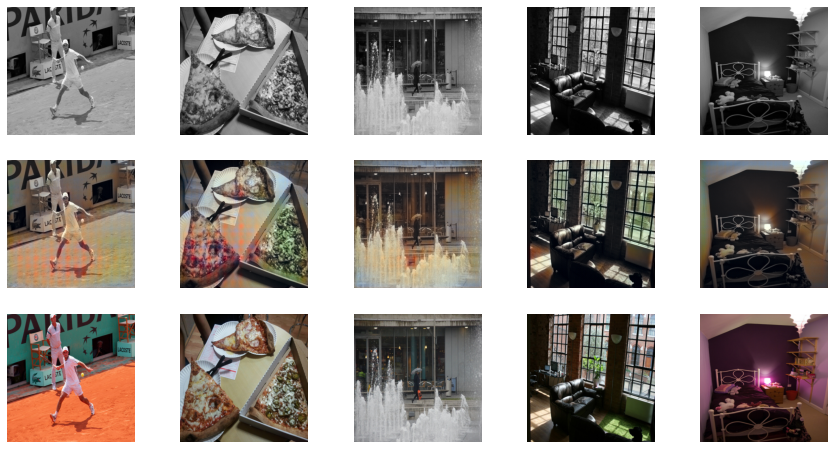

100%|██████████| 700/700 [06:27<00:00,  1.80it/s]


In [ ]:
losses = train_model(model, trainloader, 1)

## Plotting Loss Graph

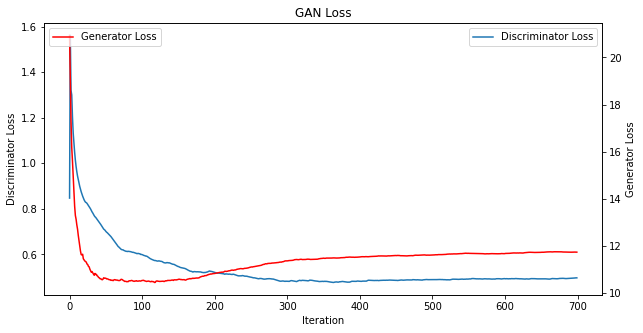

In [ ]:

fig, ax1 = plt.subplots(figsize=(10,5))
plt.title('GAN Loss')
ax2 = ax1.twinx()
ax1.plot(losses[2])
ax1.set_ylabel('Discriminator Loss')
ax1.set_xlabel('Iteration')
ax2.plot(losses[5],'r')
ax2.set_ylabel('Generator Loss')
ax1.legend(['Discriminator Loss'])
ax2.legend(['Generator Loss'],loc ="upper left")
plt.show()

## Testing

100%|█████████▉| 299/300 [01:05<00:00,  4.56it/s]

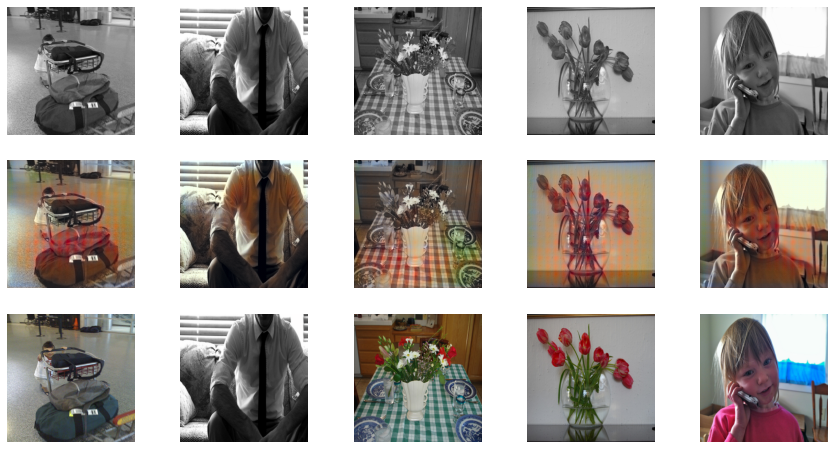

100%|██████████| 300/300 [01:06<00:00,  4.51it/s]


In [ ]:
log_every=300
i=0
for data in tqdm(testloader):
    model.setup_input(data)
    i += 1
    if i % log_every == 0:
        visualize(model,data)